In [ ]:
# !pip install xgboost
# !pip install optuna
# !pip install catboost
# !pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

import optuna
from optuna.samplers import TPESampler

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data & EDA

Грузим данные:

In [ ]:
train_target = pd.read_csv("train_target.csv") #промо выданные за ноябрь с фактом заказа
test = pd.read_csv("test.csv") #промо выданные за ноябрь без таргета
orders = pd.read_csv("orders.csv") #заказы клиентов (до ноября 10 последних заказов клиента)
mobile_events = pd.read_csv("mobile_events.csv") #мобильные евенты (за октябрь)
clients_promo_october = pd.read_csv("clients_promo_october.csv") #промо выданные за октябрь
submit = pd.read_csv("submit.csv") #пример сабмита

print('train_target:', train_target.shape)
print('test:', test.shape)
print('orders:', orders.shape)
print('mobile_events:', mobile_events.shape)
print('clients_promo_october:', clients_promo_october.shape)
print('submit:', submit.shape)

train_target: (27741, 8)
test: (6806, 7)
orders: (611739, 18)
mobile_events: (3916654, 5)
clients_promo_october: (477275, 7)
submit: (6806, 1)


## 1.1 train_target

In [ ]:
display(train_target.head()) 
train_target.info()

,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount,apply_promo
0,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0
1,000D3A20F23EA95811E7B99F3ED09FC8,6,"1,2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,1249,25,0
2,000D3A20F23EA95811E7BD373E79565E,5,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,799,200,0
3,000D3A20F23EA95811E7BD373E79565E,5,"1,2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,1249,250,0
4,000D3A20F23EA95811E7BDAE71CD3F33,6,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,30,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27741 entries, 0 to 27740
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ClientUUId      27741 non-null  object
 1   Id              27741 non-null  int64 
 2   OrderType       27741 non-null  object
 3   LocalBeginDate  27741 non-null  object
 4   LocalEndDate    27741 non-null  object
 5   OrderPrice      27741 non-null  int64 
 6   Discount        27741 non-null  int64 
 7   apply_promo     27741 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 1.7+ MB


In [ ]:
#баланс таргетов
train_target.apply_promo.value_counts(normalize=True)

apply_promo
0    0.970189
1    0.029811
Name: proportion, dtype: float64

In [ ]:
#диапазон дат в трейне
train_target['LocalBeginDate'] = pd.to_datetime(train_target['LocalBeginDate'])
train_target['LocalEndDate'] = pd.to_datetime(train_target['LocalEndDate'])

print('dates from:', train_target.LocalBeginDate.min())
print('dates to:', train_target.LocalEndDate.max())

dates from: 2023-11-02 00:00:00+00:00
dates to: 2023-11-05 23:59:00+00:00


In [ ]:
#все даты действия кампании одинаковые
display(train_target['LocalBeginDate'].value_counts())
display(train_target['LocalEndDate'].value_counts())

LocalBeginDate
2023-11-02 00:00:00+00:00    27741
Name: count, dtype: int64

LocalEndDate
2023-11-05 23:59:00+00:00    27741
Name: count, dtype: int64

In [ ]:
#сколько уникальных клиентов
print('уникальные клиенты:', len(train_target.ClientUUId.unique()))

уникальные клиенты: 18598


In [ ]:
#какое покрытие клиентов из orders, mobile_events, clients_promo_october
print('покрытие клиентов из orders:', len(set(train_target.ClientUUId.unique()).intersection(set(orders.ClientUUId.unique()))) / len(train_target.ClientUUId.unique()))
print('покрытие клиентов из mobile_events:', len(set(train_target.ClientUUId.unique()).intersection(set(mobile_events.ClientUUId.unique()))) / len(train_target.ClientUUId.unique()))
print('покрытие клиентов из clients_promo_october:', len(set(train_target.ClientUUId.unique()).intersection(set(clients_promo_october.ClientUUId.unique()))) / len(train_target.ClientUUId.unique()))

покрытие клиентов из orders: 0.538928917087859
покрытие клиентов из mobile_events: 0.9943542316378106
покрытие клиентов из clients_promo_october: 1.0


In [ ]:
#распредление Id - механика скидки, 5 - рубли, 6 - проценты, 7 - койны (по сути равны рублям)
train_target.Id.value_counts(normalize=True)

Id
7    0.420425
5    0.330594
6    0.248982
Name: proportion, dtype: float64

In [ ]:
#распределение типа заказа, 2,3 - акция для ресторанов, 1,2,3 - акция для доставки/ресторана
train_target.OrderType.value_counts(normalize=True)

OrderType
2,3      0.585956
1,2,3    0.414044
Name: proportion, dtype: float64

In [ ]:
#какие суммы заказов бывают
train_target.OrderPrice.value_counts(normalize=True)

OrderPrice
799     0.372950
1249    0.307956
699     0.104250
749     0.097942
599     0.017483
1199    0.016474
1049    0.014924
1149    0.013987
1099    0.013770
999     0.012509
949     0.011283
899     0.008796
849     0.005948
649     0.001730
Name: proportion, dtype: float64

In [ ]:
#какие скидки самые частые
train_target.Discount.value_counts(normalize=True)

Discount
200    0.436790
250    0.186727
20     0.133196
150    0.087199
25     0.072276
30     0.038427
300    0.027577
130    0.010995
15     0.005083
100    0.001730
Name: proportion, dtype: float64

In [ ]:
#есть ли значимая разница в конверсии в разных Id
print('Id=5:', train_target[train_target.Id==5]['apply_promo'].sum() / train_target[train_target.Id==5]['apply_promo'].count())
print('Id=6:', train_target[train_target.Id==6]['apply_promo'].sum() / train_target[train_target.Id==6]['apply_promo'].count())
print('Id=7:', train_target[train_target.Id==7]['apply_promo'].sum() / train_target[train_target.Id==7]['apply_promo'].count())

Id=5: 0.03151237596772435
Id=6: 0.03460257709570001
Id=7: 0.025636628654720054


In [ ]:
#есть ли разница в конверсии в разных типах заказа
print('2,3:', train_target[train_target.OrderType=='2,3']['apply_promo'].sum() / train_target[train_target.OrderType=='2,3']['apply_promo'].count())
print('1,2,3:', train_target[train_target.OrderType=='1,2,3']['apply_promo'].sum() / train_target[train_target.OrderType=='1,2,3']['apply_promo'].count())

2,3: 0.02577668409720086
1,2,3: 0.035521504440188055


In [ ]:
#конверсия для разных скидок
train_target.groupby('Discount')['apply_promo'].sum() / train_target.groupby('Discount')['apply_promo'].count()

Discount
15     0.028369
20     0.030311
25     0.032918
30     0.053471
100    0.041667
130    0.045902
150    0.021496
200    0.025666
250    0.032046
300    0.056209
Name: apply_promo, dtype: float64

In [ ]:
#конверсия для разных сумм заказов
train_target.groupby('OrderPrice')['apply_promo'].sum() / train_target.groupby('OrderPrice')['apply_promo'].count()

OrderPrice
599     0.037113
649     0.083333
699     0.022822
749     0.029076
799     0.025324
849     0.066667
899     0.036885
949     0.060703
999     0.028818
1049    0.031401
1099    0.028796
1149    0.020619
1199    0.037199
1249    0.035116
Name: apply_promo, dtype: float64

## 1.2 orders

In [ ]:
display(orders.head())
orders.info()

,OrderUUId,addressId,deliverySectorId,ClientUUId,Date,SaleDate,UnitUUId,NewClient,ClientOrderNumber,ProductUUId,CategoryId,ProductTotalPrice,MenuPrice,OrderState,OrderPaymentType,OrderTotalPrice,OrderType,apply_promo
0,020DD76CCD949AE011EDE031ED5D76FD,NaN,NaN,000D3AAC9DCABB2E11EBE0614C89D044,2023-04-21,2023-04-21T20:51:26.000Z,000D3A2480C380DA11E692CFB9F92484,0,18,000D3A240C71BE9A11E719BE2AB264A6,4,1.0,45.0,4,2,1.0,3,0
1,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02T21:31:32.000Z,000D3A26B5B080DF11E745FD0474B95C,0,29,11EC9AABAD354BE051CCF1EE1F83A8D0,1,485.0,485.0,4,2,1164.0,1,0
2,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02T21:31:32.000Z,000D3A26B5B080DF11E745FD0474B95C,0,29,11EB846583CB3BDEA80D1A7F2E184D40,1,589.0,589.0,4,2,1164.0,1,0
3,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02T21:31:32.000Z,000D3A26B5B080DF11E745FD0474B95C,0,29,000D3A240C71BE9A11E719BE2AB267FD,4,45.0,45.0,4,2,1164.0,1,0
4,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02T21:31:32.000Z,000D3A26B5B080DF11E745FD0474B95C,0,29,000D3A240C71BE9A11E719BE2AB264A6,4,45.0,45.0,4,2,1164.0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611739 entries, 0 to 611738
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   OrderUUId          611739 non-null  object 
 1   addressId          488325 non-null  float64
 2   deliverySectorId   488325 non-null  float64
 3   ClientUUId         611739 non-null  object 
 4   Date               611739 non-null  object 
 5   SaleDate           611739 non-null  object 
 6   UnitUUId           611739 non-null  object 
 7   NewClient          611739 non-null  int64  
 8   ClientOrderNumber  611739 non-null  int64  
 9   ProductUUId        611739 non-null  object 
 10  CategoryId         611739 non-null  int64  
 11  ProductTotalPrice  611739 non-null  float64
 12  MenuPrice          611739 non-null  float64
 13  OrderState         611739 non-null  int64  
 14  OrderPaymentType   611739 non-null  int64  
 15  OrderTotalPrice    611739 non-null  float64
 16  Or

In [ ]:
print('уникальных заказов:', len(orders.OrderUUId.unique()))
print('в среднем продуктов в заказе:', orders.groupby('OrderUUId')['ProductUUId'].count().mean())
print('минимально продуктов в заказе:', orders.groupby('OrderUUId')['ProductUUId'].count().min())
print('максимально продуктов в заказе:', orders.groupby('OrderUUId')['ProductUUId'].count().max())

уникальных заказов: 157621
в среднем продуктов в заказе: 3.8810754912099275
минимально продуктов в заказе: 1
максимально продуктов в заказе: 220


In [ ]:
#адрес и сектор доставки, есть пропуска, много нулей - возможно это заказы в ресторане (без доставки)
display(orders.addressId.describe())
print('разные адреса:', len(orders.addressId.unique()))
display(orders.deliverySectorId.describe())
print('разные сектора:', len(orders.deliverySectorId.unique()))

count    4.883250e+05
mean     2.964650e+05
std      1.970507e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.809518e+07
Name: addressId, dtype: float64

разные адреса: 2707


count    488325.000000
mean         81.843000
std         588.142806
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        6798.000000
Name: deliverySectorId, dtype: float64

разные сектора: 1260


In [ ]:
#проверим гипотезу, что нули в доставке - это заказы в ресторане (1 - доставка)
orders[orders.addressId==0]['OrderType'].value_counts()

OrderType
1    474432
2        44
3        19
Name: count, dtype: int64

In [ ]:
#гипотеза не подтвердилась, а вот пропуски судя по всему действительно - заказы в ресторане (2,3 - ресторан)
orders[orders.addressId.isnull()]['OrderType'].value_counts()

OrderType
3    122584
2       829
1         1
Name: count, dtype: int64

In [ ]:
#посмотрим за какой период есть данные 
orders['Date'] = pd.to_datetime(orders['Date'])
orders['SaleDate'] = pd.to_datetime(orders['SaleDate'])

print('orders from:', orders.Date.min())
print('orders to:', orders.Date.max())

orders from: 2023-03-15 00:00:00
orders to: 2023-10-31 00:00:00


In [ ]:
#кол-во уникальных пиццерий
print('unique unit:',len(orders.UnitUUId.unique()))

unique unit: 784


In [ ]:
#какая доля заказов со статусом новый клиент
print('new clients share:', orders.groupby(['OrderUUId'])['NewClient'].max().sum() / len(orders.ClientUUId.unique()))

new clients share: 0.006733182346820102


In [ ]:
#обратим внимание, что нумерация заказов бывает не последовательной и начинается не с нуля для этой таблицы
orders[orders.ClientUUId=='000D3ABF84C3BB2E11EC04E346FE4AC8'][['OrderUUId','Date','ClientOrderNumber']].sort_values(by='Date')

,OrderUUId,Date,ClientOrderNumber
370021,9AA060DC58459DF311EE44E093A69910,2023-08-27,3
370022,9AA060DC58459DF311EE44E093A69910,2023-08-27,3
370023,9AA060DC58459DF311EE44E093A69910,2023-08-27,3
28,02228E7CAAA7ABAE11EE469CBA09C587,2023-08-29,4
29,02228E7CAAA7ABAE11EE469CBA09C587,2023-08-29,4
30,02228E7CAAA7ABAE11EE469CBA09C587,2023-08-29,4
309964,CE2DE6B1DB1A9D1611EE4A91EA3CB9AC,2023-09-05,6
515510,6246EB810501A37811EE4CD5C04276DC,2023-09-06,7
122979,32425E0C43CAB00B11EE4DA4A5835456,2023-09-14,9
74744,520AE436B34B839D11EE5D5CDEDE9C8D,2023-09-27,13


In [ ]:
#также есть сомнительно большие кол-ва заказов
orders.ClientOrderNumber.max()

1845

In [ ]:
#сколько уникальный продуктов
print('unique product cnt:',len(orders.ProductUUId.unique()))

unique product cnt: 507


In [ ]:
#соберем отдельно продукты с учетом их популярности(частоты заказов)
products = pd.DataFrame(orders.ProductUUId.value_counts(normalize=True)).reset_index().sort_values('proportion', ascending=False)
products = products.rename(columns={'proportion': 'product_proportion'})
products.head()

,ProductUUId,product_proportion
0,000D3A240C71BE9A11E719BE2AB2D427,0.062214
1,11EBADD5B90B8B4F0F2EF40F4E6B5B70,0.057910
2,000D3A240C71BE9A11E719BE2AB264A6,0.043626
3,11ED276CA17B3D3016833EF686833390,0.019703
4,11ECC9D29BACC18D6DC677D4F09E15D0,0.019567


In [ ]:
#категории товаров
orders.CategoryId.value_counts(normalize=True)

CategoryId
1    0.315566
3    0.276888
5    0.124202
6    0.098305
2    0.090544
4    0.087093
7    0.007403
Name: proportion, dtype: float64

In [ ]:
#распределение цен по меню и с учетом скидок, интересно что есть нулевые цены
display(orders.MenuPrice.describe())
display(orders.ProductTotalPrice.describe())

count    611739.000000
mean        284.286601
std         257.768164
min           0.000000
25%         109.000000
50%         199.000000
75%         419.000000
max        2199.000000
Name: MenuPrice, dtype: float64

count    611739.000000
mean        232.922882
std         234.839101
min           0.000000
25%          36.000000
50%         169.000000
75%         359.000000
max        1999.000000
Name: ProductTotalPrice, dtype: float64

In [ ]:
#разбремся что за нулевые цены, посмотрим что это за продукты и сколько их
#возможно это приборы или что-то такое
orders[orders.MenuPrice==0]['ProductUUId'].value_counts()

ProductUUId
11EBADD5B90B8B4F0F2EF40F4E6B5B70    35426
11EBADD4B90B8B4F0F2EF40F8BDAB3D0    11374
11EBADD3B90B8B4F0F2EF40F26029420     7738
11EB2EF1A0F1FB35FE0B4C13BC2501B0     7241
11EBADD4B90B8B4F0F2EF40F237A6D30     4260
11EBADD4B90B8B4F0F2EF40FCA811020     4171
11EDE68E83BF6D3A306E00850D4DF230     2567
11EDD008AE5C213182375BCB23506320      302
11EBB7A29AD28F454198D4BE12620210       83
11ED90FAB2D7DD2E05B17728320426B0       33
11ED90FAB2D7DD2E05B17728FF919C70       21
11EE6393AF4DC7DB3A4928243ABA6320       10
11EE6393AF4DC7DB3A492824A3CE9070        3
11EE2E5BB16333CC343980071C5B6F40        2
Name: count, dtype: int64

In [ ]:
#большая часть продуктов везде стоит 0, но есть кейсы с разной ценой для одного продукта
#возможно это какие-то временные акции, типа что-то при заказе идёт в подарок
display(orders[(orders.ProductUUId=='11EDD008AE5C213182375BCB23506320')&(orders.MenuPrice==0)].head(1))
display(orders[(orders.ProductUUId=='11EDD008AE5C213182375BCB23506320')&(orders.MenuPrice!=0)].head(1))

,OrderUUId,addressId,deliverySectorId,ClientUUId,Date,SaleDate,UnitUUId,NewClient,ClientOrderNumber,ProductUUId,CategoryId,ProductTotalPrice,MenuPrice,OrderState,OrderPaymentType,OrderTotalPrice,OrderType,apply_promo
1698,4A4F363CEC56B4B411EDF08EC084B066,0.0,0.0,000D3A23B0DC80DC11E7322D41C9BDDD,2023-05-12,2023-05-12T11:46:14.000Z,000D3A23B0DC80DB11E6EF54FD408485,0,71,11EDD008AE5C213182375BCB23506320,5,0.0,0.0,4,2,962.0,1,1


,OrderUUId,addressId,deliverySectorId,ClientUUId,Date,SaleDate,UnitUUId,NewClient,ClientOrderNumber,ProductUUId,CategoryId,ProductTotalPrice,MenuPrice,OrderState,OrderPaymentType,OrderTotalPrice,OrderType,apply_promo
1871,527A807E2237A3AD11EE5888E76CF4BE,0.0,0.0,000D3A39D824A82E11E9AE50A746B80D,2023-09-22,2023-09-22T19:24:30.000Z,000D3A21DA51A81211E97E014D6927E2,0,71,11EDD008AE5C213182375BCB23506320,5,0.0,189.0,4,2,1028.0,1,0


In [ ]:
#статус заказов, возможно 11 - это отмененные заказы, т.к их очень мало
orders.OrderState.value_counts(normalize=True)

OrderState
4     0.986386
11    0.013614
Name: proportion, dtype: float64

In [ ]:
#тип платежа, скорее всего - онлайн, карта, наличка
orders.OrderPaymentType.value_counts(normalize=True)

OrderPaymentType
2    0.899643
0    0.069840
1    0.030516
Name: proportion, dtype: float64

In [ ]:
#общая сумма заказов, есть заказы на 0 рублей, есть заказы на 99418 рублей
orders.groupby('OrderUUId')['OrderTotalPrice'].max().describe()

count    157621.000000
mean        903.991289
std         647.582719
min           0.000000
25%         579.000000
50%         818.000000
75%        1149.000000
max       99418.000000
Name: OrderTotalPrice, dtype: float64

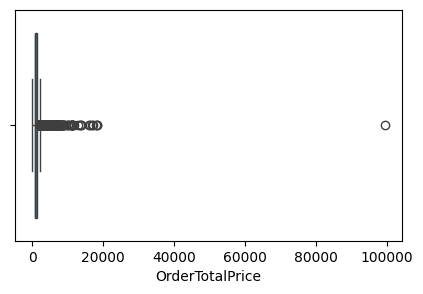

In [ ]:
#глянем чё по выбросам, есть сомнительно дорогие заказы, интересно сколько их
#возможно заказ на какое-то мероприятие
plt.figure(figsize=(5,3))
sns.boxplot(x=orders.groupby('OrderUUId')['OrderTotalPrice'].max());

In [ ]:
#типы заказов, в основном доставка
orders.OrderType.value_counts(normalize=True)

OrderType
1    0.798133
3    0.200417
2    0.001450
Name: proportion, dtype: float64

In [ ]:
#баланс таргетов, интересно, что здесь гораздо выше конверсия чем в train
orders.groupby('OrderUUId')['apply_promo'].max().value_counts(normalize=True)

apply_promo
0    0.843155
1    0.156845
Name: proportion, dtype: float64

## 1.3 mobile_events

In [ ]:
display(mobile_events.head())
mobile_events.info()

,ClientUUId,VisitToken,EventName,Platform,Timestamp
0,000D3A22FA54A81611EB315CF5443815,976627AD-76DC-41D9-981E-F2A6CA14B3A9,screen_menu,ios,2023-10-29T16:14:21.343Z
1,2A4A64AF719E994511EE3F2D8B31E188,5b22e610-c71e-4b6a-a842-71e8575ece87,screen_menu,android,2023-10-29T11:04:36.4840000Z
2,000D3AAC977BBB2F11ECDD081F5481AE,BDCEB72F-2B6A-4565-801A-6CB729279C6F,open_app,ios,2023-10-29T11:14:34.723Z
3,000D3A21DA51A81411EAE468856F96F1,A66E2DA6-4E2E-4C37-9FBF-627732623212,add_to_cart,ios,2023-10-29T14:03:08.363Z
4,000D3A23B0DC80D811E67F4D0A9CA345,1BE8139F-A3D3-439F-A51B-5CBD4D3FFF1B,screen_menu,ios,2023-10-29T08:35:40.127Z


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3916654 entries, 0 to 3916653
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   ClientUUId  object
 1   VisitToken  object
 2   EventName   object
 3   Platform    object
 4   Timestamp   object
dtypes: object(5)
memory usage: 149.4+ MB


In [ ]:
print('уникальных визитов:', len(mobile_events.VisitToken.unique()))
print('в среднем дествий у пользователя:', mobile_events.groupby('ClientUUId')['VisitToken'].count().mean())
print('максимальное кол-во дествий у пользователя:', mobile_events.groupby('ClientUUId')['VisitToken'].count().max())
print('минимальное кол-во действий у пользователя:', mobile_events.groupby('ClientUUId')['VisitToken'].count().min())

уникальных визитов: 223964
в среднем дествий у пользователя: 131.26395871036934
максимальное кол-во дествий у пользователя: 2257
минимальное кол-во действий у пользователя: 2


In [ ]:
#какие евенты бывают
mobile_events.EventName.value_counts(normalize=True)

EventName
screen_menu             0.239870
open_app                0.180201
close_app               0.175200
screen_cart             0.094134
open_product_card       0.092650
add_to_cart             0.081480
screen_profile          0.075507
remove_from_cart        0.028852
create_order            0.019152
apply_personal_offer    0.006859
open_bonusaction        0.006097
Name: proportion, dtype: float64

In [ ]:
#по платформам +- ровно
mobile_events.Platform.value_counts(normalize=True)

Platform
ios        0.511411
android    0.488589
Name: proportion, dtype: float64

In [ ]:
#период дат
mobile_events['Timestamp'] = pd.to_datetime(mobile_events['Timestamp'])

print('mobile events from:', mobile_events.Timestamp.min())
print('mobile events to:', mobile_events.Timestamp.max())

mobile events from: 2022-10-07 13:07:21.818999900+00:00
mobile events to: 2023-11-01 15:01:54.483000+00:00


In [ ]:
#эвенты должны быть за октябрь, посмотрим сколько записей не в октябре
#0.4% не страшно
len(mobile_events[mobile_events.Timestamp.dt.month!=10])/len(mobile_events)

0.004137204869258301

## 1.4 clients_promo_october

In [ ]:
display(clients_promo_october.head())
clients_promo_october.info()

,ClientUUId,Id,LocalBeginDate,LocalEndDate,OrderType,OrderPrice,Discount
0,000D3A20F23EA95811E7B7104AC23CD3,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,25
1,000D3A20F23EA95811E7B7D79FAABAA1,5,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,300
2,000D3A20F23EA95811E7B8BD71C73877,7,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1249,200
3,000D3A20F23EA95811E7B99F3ED09FC8,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1249,30
4,000D3A20F23EA95811E7BD373E79565E,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477275 entries, 0 to 477274
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ClientUUId      477275 non-null  object
 1   Id              477275 non-null  int64 
 2   LocalBeginDate  477275 non-null  object
 3   LocalEndDate    477275 non-null  object
 4   OrderType       477275 non-null  object
 5   OrderPrice      477275 non-null  int64 
 6   Discount        477275 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 25.5+ MB


In [ ]:
print('сколько человек получило промокоды:', len(clients_promo_october.ClientUUId.unique()))
print('среднее кол-во промокодов:', clients_promo_october.groupby('ClientUUId')['Id'].count().mean())
print('макимальное кол-во промокодов:', clients_promo_october.groupby('ClientUUId')['Id'].count().max())
print('минимальное кол-во промокодов:', clients_promo_october.groupby('ClientUUId')['Id'].count().min())

сколько человек получило промокоды: 30000
среднее кол-во промокодов: 15.909166666666666
макимальное кол-во промокодов: 18
минимальное кол-во промокодов: 1


In [ ]:
#период дат
clients_promo_october['LocalBeginDate'] = pd.to_datetime(clients_promo_october['LocalBeginDate'])
clients_promo_october['LocalEndDate'] = pd.to_datetime(clients_promo_october['LocalEndDate'])

print('clients_promo_october from:', clients_promo_october['LocalBeginDate'].min())
print('clients_promo_october to:', clients_promo_october['LocalEndDate'].max())

clients_promo_october from: 2023-10-02 00:00:00+00:00
clients_promo_october to: 2023-11-01 23:59:00+00:00


In [ ]:
#по типам заказов одинаково, скорее промокоды дублируют и для доставки и для ресторанов
clients_promo_october.OrderType.value_counts(normalize=True)

OrderType
1,2,3    0.501405
2,3      0.498595
Name: proportion, dtype: float64

In [ ]:
#пороги срабатывания промо
clients_promo_october.OrderPrice.value_counts(normalize=True)

OrderPrice
799     0.233392
1249    0.174757
749     0.116790
1399    0.083864
1299    0.077901
1199    0.058916
699     0.043233
949     0.041986
1099    0.032847
899     0.025660
1149    0.023609
1049    0.022503
999     0.022295
849     0.020380
599     0.010652
1349    0.006001
649     0.005215
Name: proportion, dtype: float64

In [ ]:
#скидки
#10% в трейне нету например
clients_promo_october.Discount.value_counts(normalize=True)

Discount
20     0.234249
200    0.206170
250    0.167103
25     0.101510
300    0.076985
150    0.069042
15     0.065164
30     0.056850
10     0.010897
100    0.008624
130    0.003407
Name: proportion, dtype: float64

# 2. Feature engineering

## 2.1 orders features

In [ ]:
#функция для оценки популярности продукта, кодируем по частоте заказов
def get_popular_product(x):
    if x < 0.01:
        return 0
    elif x >= 0.01 and x < 0.03:
        return 1
    else:
        return 2

#накатываем функцию и делаем фичу popular_product
orders = orders.merge(products, how='left', on='ProductUUId')
orders['popular_product'] = orders.product_proportion.apply(get_popular_product)
orders.popular_product.value_counts()

popular_product
0    336767
1    174799
2    100173
Name: count, dtype: int64

In [ ]:
#накатываем время заказа
orders['SaleHour'] = pd.to_datetime(orders.SaleDate).dt.hour

#функция кодируем период заказа утро/день/вечер/ночь
def get_time(x):
    if x >= 5 and x < 10: 
        return 0
    elif x >= 10 and x < 15: 
        return 1
    elif x >= 15 and x < 20: 
        return 2
    elif x >= 20 and x < 24: 
        return 3
    else:  
        return 4    

orders['SaleTime'] = orders.SaleHour.apply(get_time)
orders.SaleTime.value_counts()

SaleTime
2    267209
1    180487
3    144625
0     12924
4      6494
Name: count, dtype: int64

In [ ]:
#выделим заказы только за октябрь
orders_october = orders[orders.SaleDate.dt.month==10]

#считаем кол-во заказов в октябре
cnt_orders_october = pd.DataFrame(orders_october.groupby(['ClientUUId', 'OrderUUId'])['ProductUUId'].count()).reset_index().groupby('ClientUUId')['OrderUUId'].count().reset_index()
cnt_orders_october = cnt_orders_october.rename(columns={'OrderUUId': 'cnt_orders_october'})

#сколько всего было выдано промо за октябрь (там есть не толко октябрь но мало, в идеале фильтрануть)
cnt_promo_promo = pd.DataFrame(clients_promo_october.groupby(['ClientUUId'])['Id'].count()).reset_index()
cnt_promo_promo= cnt_promo_promo.rename(columns={'Id': 'cnt_promo'})

#из промо берем только кол-во промокодов, остальные фичи особо не заходят
promo_features = cnt_promo_promo

#считаем отношение высланных и примененных промокодов в октябре
october_data = cnt_orders_october.merge(cnt_promo_promo, how='inner', on='ClientUUId')
october_data['promo_rate'] = october_data.cnt_orders_october / october_data.cnt_promo
promo_rate = october_data[['ClientUUId','promo_rate']]

#кол-во заказов
cnt_orders = pd.DataFrame(orders.groupby(['ClientUUId', 'OrderUUId'])['ProductUUId'].count()).reset_index().groupby('ClientUUId')['OrderUUId'].count().reset_index()
cnt_orders = cnt_orders.rename(columns={'OrderUUId': 'cnt_orders'})

#сумма заказов
sum_orders = pd.DataFrame(pd.DataFrame(orders.groupby(['ClientUUId','OrderUUId'])['OrderTotalPrice'].max()).reset_index().groupby('ClientUUId')['OrderTotalPrice'].sum()).reset_index()
sum_orders = sum_orders.rename(columns={'OrderTotalPrice': 'sum_orders'})

#кол-во промокодов
cnt_promo_orders = pd.DataFrame(pd.DataFrame(orders.groupby(['ClientUUId','OrderUUId'])['apply_promo'].max()).reset_index().groupby('ClientUUId')['apply_promo'].sum()).reset_index()
cnt_promo_orders = cnt_promo_orders.rename(columns={'apply_promo': 'cnt_promo_orders'})

#наиболее частый тип заказа
main_type_orders = pd.DataFrame(pd.DataFrame(orders.groupby(['ClientUUId','OrderUUId'])['OrderType'].max()).reset_index().groupby('ClientUUId')['OrderType'].median()).reset_index()
main_type_orders = main_type_orders.rename(columns={'OrderType': 'main_type_orders'})

#максимальная сумма заказа
max_orders = pd.DataFrame(pd.DataFrame(orders.groupby(['ClientUUId','OrderUUId'])['OrderTotalPrice'].max()).reset_index().groupby('ClientUUId')['OrderTotalPrice'].max()).reset_index()
max_orders = max_orders.rename(columns={'OrderTotalPrice': 'max_orders'})

#наиболее частое время заказа
main_time_orders = pd.DataFrame(pd.DataFrame(orders.groupby(['ClientUUId','OrderUUId'])['SaleTime'].max()).reset_index().groupby('ClientUUId')['SaleTime'].median()).reset_index()
main_time_orders = main_time_orders.rename(columns={'SaleTime': 'main_time_orders'})

#основной способ платежа
main_payment_orders = pd.DataFrame(pd.DataFrame(orders.groupby(['ClientUUId','OrderUUId'])['OrderPaymentType'].max()).reset_index().groupby('ClientUUId')['OrderPaymentType'].median()).reset_index()
main_payment_orders = main_payment_orders.rename(columns={'OrderPaymentType': 'main_payment_orders'})

#сумма заказов по меню
menu_sum_orders = pd.DataFrame(pd.DataFrame(orders.groupby(['ClientUUId','OrderUUId'])['MenuPrice'].sum()).reset_index().groupby('ClientUUId')['MenuPrice'].sum()).reset_index()
menu_sum_orders = menu_sum_orders.rename(columns={'MenuPrice': 'menu_sum_orders'})

#основная категория товаров
main_categoryid_orders = pd.DataFrame(pd.DataFrame(orders.groupby(['ClientUUId','OrderUUId'])['CategoryId'].median()).reset_index().groupby('ClientUUId')['CategoryId'].median()).reset_index()
main_categoryid_orders = main_categoryid_orders.rename(columns={'CategoryId': 'main_categoryid_orders'})

#популярные продукты, из заказа берем самый популярный
main_popular_product_orders = pd.DataFrame(pd.DataFrame(orders.groupby(['ClientUUId','OrderUUId'])['popular_product'].max()).reset_index().groupby('ClientUUId')['popular_product'].median()).reset_index()
main_popular_product_orders = main_popular_product_orders.rename(columns={'popular_product': 'main_popular_product_orders'})

#на сколько в среднем дешевле заказы, по сути скидка
menu_sum_diff_rate = pd.concat([sum_orders.ClientUUId, (menu_sum_orders.menu_sum_orders - sum_orders.sum_orders) /  menu_sum_orders.menu_sum_orders], axis=1)
menu_sum_diff_rate  = menu_sum_diff_rate.rename(columns={0: 'menu_sum_diff_rate '})

#все фичи по заказам
orders_features = cnt_orders
orders_features = orders_features.merge(sum_orders, on='ClientUUId', how='left')
orders_features = orders_features.merge(cnt_promo_orders, on='ClientUUId', how='left')
orders_features = orders_features.merge(main_type_orders, on='ClientUUId', how='left')
orders_features = orders_features.merge(max_orders, on='ClientUUId', how='left')
orders_features = orders_features.merge(main_time_orders, on='ClientUUId', how='left')
orders_features = orders_features.merge(main_payment_orders, on='ClientUUId', how='left')
orders_features = orders_features.merge(menu_sum_orders, on='ClientUUId', how='left')
orders_features = orders_features.merge(main_categoryid_orders, on='ClientUUId', how='left')
orders_features = orders_features.merge(main_popular_product_orders, on='ClientUUId', how='left')
orders_features = orders_features.merge(menu_sum_diff_rate, on='ClientUUId', how='left')
orders_features = orders_features.merge(promo_rate, on='ClientUUId', how='left')

#какой платформой пользуется чел
platform_mobile = pd.DataFrame(mobile_events.groupby(['ClientUUId'])['Platform'].max()).reset_index()
platform_mobile = platform_mobile.rename(columns={'Platform': 'platform_mobile'})

#сколько было визитов
cnt_visit_mobile = pd.DataFrame(mobile_events.groupby(['ClientUUId'])['VisitToken'].count()).reset_index()
cnt_visit_mobile = cnt_visit_mobile.rename(columns={'VisitToken': 'cnt_visit_mobile'})

#сколько было событий не учитывая открыл/закрыл
cnt_active_visit_mobile = pd.DataFrame(mobile_events[(mobile_events.EventName!='open_app')&(mobile_events.EventName!='close_app')].groupby(['ClientUUId'])['VisitToken'].count()).reset_index()
cnt_active_visit_mobile = cnt_active_visit_mobile.rename(columns={'VisitToken': 'cnt_active_visit_mobile'})

#посчитаем кол-во всех событий отдельно
clients_events_cnt = pd.DataFrame(pd.pivot_table(mobile_events, index='ClientUUId', columns='EventName', values='VisitToken', aggfunc='count', fill_value=0)).reset_index()

#все фичи по евентам
mobile_features = platform_mobile
mobile_features = mobile_features.merge(cnt_visit_mobile, how='left', on='ClientUUId')
mobile_features = mobile_features.merge(cnt_active_visit_mobile, how='left', on='ClientUUId')
mobile_features = mobile_features.merge(clients_events_cnt, how='left', on='ClientUUId')

# 3. Train sample

In [ ]:
df = train_target.copy()

#цепляем фичи
df = df.merge(orders_features, on='ClientUUId', how='left')
df = df.merge(mobile_features, on='ClientUUId', how='left')
df = df.merge(promo_features, on='ClientUUId', how='left')

df.head(3)

,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount,apply_promo,cnt_orders,sum_orders,...,close_app,create_order,open_app,open_bonusaction,open_product_card,remove_from_cart,screen_cart,screen_menu,screen_profile,cnt_promo
0,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",2023-11-02 00:00:00+00:00,2023-11-05 23:59:00+00:00,699,200,0,10.0,9179.0,...,43.0,4.0,43.0,0.0,22.0,2.0,8.0,54.0,0.0,14
1,000D3A20F23EA95811E7B99F3ED09FC8,6,"1,2,3",2023-11-02 00:00:00+00:00,2023-11-05 23:59:00+00:00,1249,25,0,10.0,9179.0,...,43.0,4.0,43.0,0.0,22.0,2.0,8.0,54.0,0.0,14
2,000D3A20F23EA95811E7BD373E79565E,5,"2,3",2023-11-02 00:00:00+00:00,2023-11-05 23:59:00+00:00,799,200,0,NaN,NaN,...,16.0,2.0,15.0,0.0,6.0,0.0,11.0,12.0,30.0,12


In [ ]:
#посомтрим значения
df.describe()

,Id,OrderPrice,Discount,apply_promo,cnt_orders,sum_orders,cnt_promo_orders,main_type_orders,max_orders,main_time_orders,...,close_app,create_order,open_app,open_bonusaction,open_product_card,remove_from_cart,screen_cart,screen_menu,screen_profile,cnt_promo
count,27741.000000,27741.000000,27741.000000,27741.000000,15020.000000,15020.000000,15020.000000,15020.000000,15020.000000,15020.000000,...,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000,27741.000000
mean,6.089831,943.219747,162.694928,0.029811,9.645606,8847.862383,1.555992,1.446638,1648.226365,1.966411,...,22.891516,2.529985,23.510877,0.791588,12.256055,3.848296,12.404242,31.467658,9.798223,15.902058
std,0.861960,225.759604,86.335719,0.170070,0.916319,3777.857666,1.949012,0.810884,1468.336520,0.583172,...,17.545173,1.369830,17.935993,1.688451,11.749442,6.348090,11.184897,25.649963,10.230939,2.823560
min,5.000000,599.000000,15.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,5.000000,799.000000,100.000000,0.000000,10.000000,6540.000000,0.000000,1.000000,1089.000000,2.000000,...,12.000000,2.000000,12.000000,0.000000,5.000000,0.000000,6.000000,16.000000,3.000000,14.000000
50%,6.000000,799.000000,200.000000,0.000000,10.000000,8377.000000,1.000000,1.000000,1419.000000,2.000000,...,18.000000,2.000000,19.000000,0.000000,9.000000,2.000000,9.000000,25.000000,7.000000,16.000000
75%,7.000000,1249.000000,200.000000,0.000000,10.000000,10697.250000,3.000000,1.000000,1909.000000,2.000000,...,29.000000,3.000000,30.000000,1.000000,16.000000,5.000000,15.000000,39.000000,13.000000,18.000000
max,7.000000,1249.000000,300.000000,1.000000,10.000000,103649.000000,10.000000,3.000000,99418.000000,4.000000,...,320.000000,92.000000,323.000000,35.000000,221.000000,221.000000,293.000000,529.000000,150.000000,18.000000


In [ ]:
#чё по пропускам
df.isna().sum()

ClientUUId                         0
Id                                 0
OrderType                          0
LocalBeginDate                     0
LocalEndDate                       0
OrderPrice                         0
Discount                           0
apply_promo                        0
cnt_orders                     12721
sum_orders                     12721
cnt_promo_orders               12721
main_type_orders               12721
max_orders                     12721
main_time_orders               12721
main_payment_orders            12721
menu_sum_orders                12721
main_categoryid_orders         12721
main_popular_product_orders    12721
menu_sum_diff_rate             12721
promo_rate                     12721
platform_mobile                  161
cnt_visit_mobile                 161
cnt_active_visit_mobile          161
add_to_cart                      161
apply_personal_offer             161
close_app                        161
create_order                     161
o

In [ ]:
#у кого не было заказов скорее всего новые клиенты, заполним их заказы нулями
#остальные фичи оставим с пропусками
df.cnt_orders = df.cnt_orders.fillna(0)
df.sum_orders = df.sum_orders.fillna(0)
df.cnt_promo_orders = df.cnt_promo_orders.fillna(0)
df.menu_sum_orders = df.menu_sum_orders.fillna(0)
df.max_orders = df.max_orders.fillna(0)

In [ ]:
#кодируем категориальные признаки
df.OrderType = df.OrderType.apply(lambda x: 1 if x == '1,2,3' else 0)
df.platform_mobile = df.platform_mobile.apply(lambda x: 0 if x == 'android' else 1)
#дропаем лишние фичи
df = df.drop(['LocalBeginDate', 'LocalEndDate', 'ClientUUId'], axis=1)

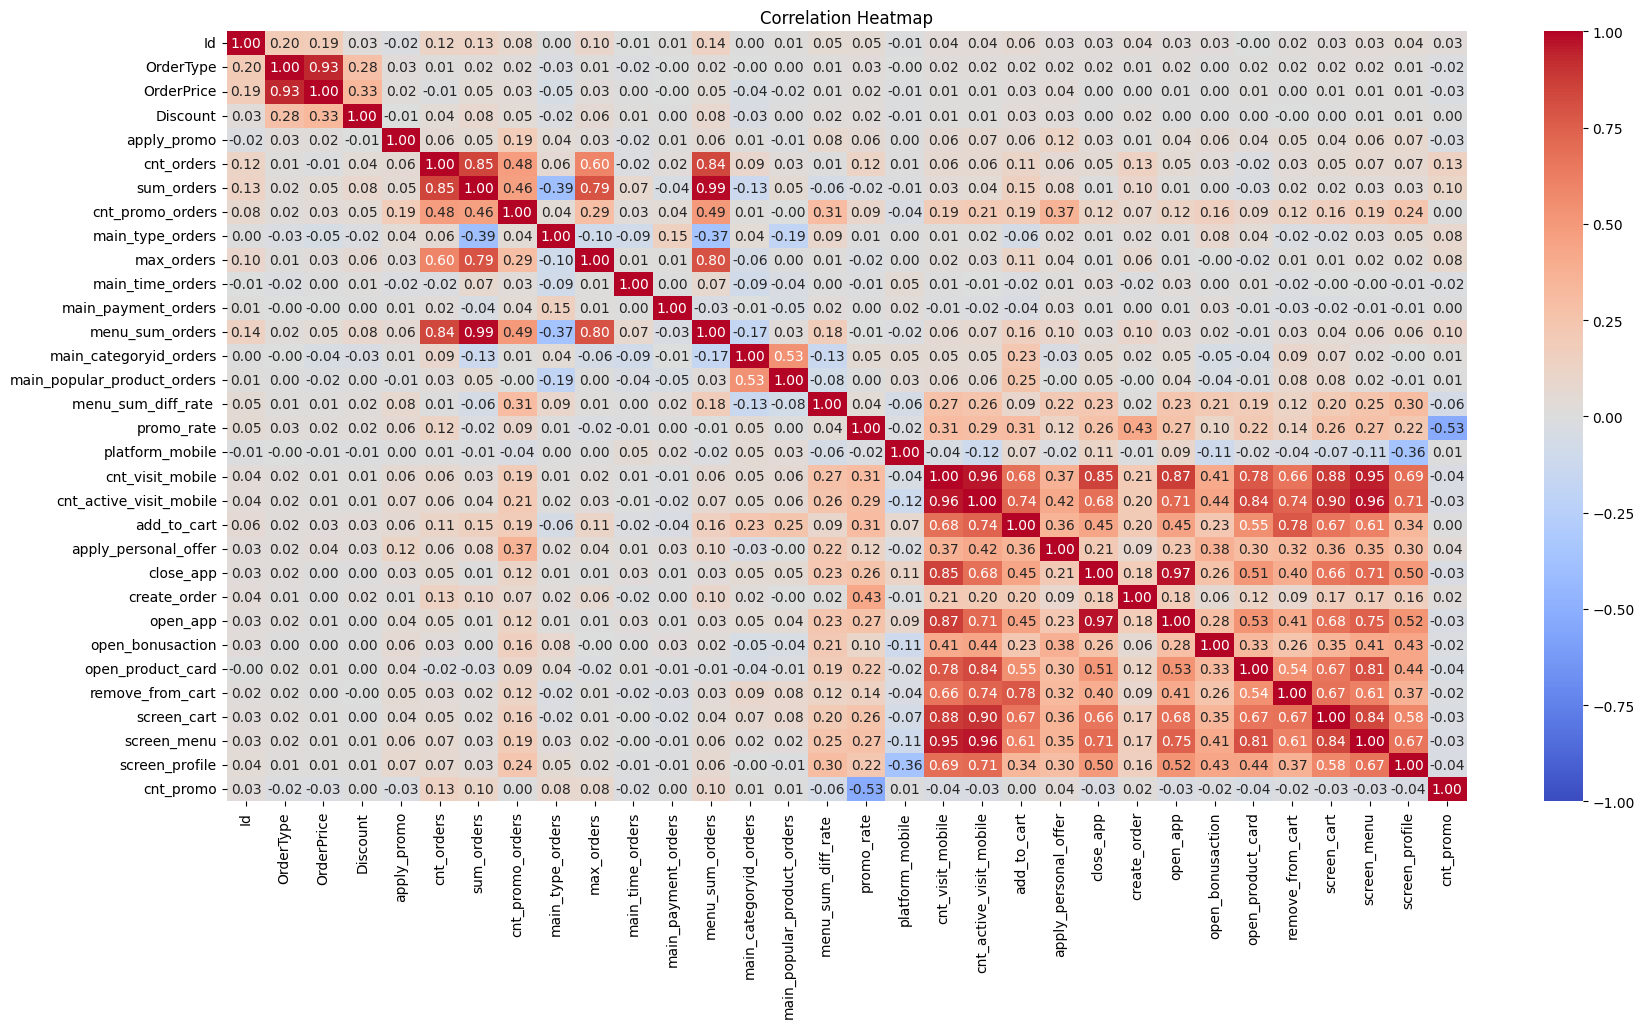

In [ ]:
#посмотрим на корреляции
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
#для всех переменных посчитаем корреляцию с таргетом
result_corr = {}
for i in df.columns:
    if i != 'apply_promo':
        r = df[['apply_promo', i]].corr().iloc[0][1]
        result_corr[i] = np.abs(r) 

corr = pd.DataFrame(result_corr, index=['corr']).T.sort_values('corr', ascending=False).reset_index()
corr = corr.rename(columns={'index': 'vars'})

#для всех переменных посчитаем индивидуальный roc_auc
result_auc = {}
for i in df.columns:
    if i != 'apply_promo':
        r = roc_auc_score(df['apply_promo'], df[i].fillna(df[i].median()))
        result_auc[i] = r 

auc = pd.DataFrame(result_auc, index=['roc_auc_score']).T.sort_values('roc_auc_score', ascending=False).reset_index()
auc = auc.rename(columns={'index': 'vars'})

#обучим буст(пускай будет переобученный, тут неважно) и оценим значимость переменных при сплите
test_boost = XGBClassifier(random_state=42, n_jobs=-1)
test_boost.fit(df.drop('apply_promo', axis=1), df['apply_promo']);
imp = pd.DataFrame({'vars':df.drop('apply_promo', axis=1).columns, 'importances':test_boost.feature_importances_}).sort_values('importances', ascending=False)

#выводим все результаты по переменным
result_features = corr.merge(imp, on='vars', how='inner')
result_features = result_features.merge(auc, on='vars', how='inner')
result_features

,vars,corr,importances,roc_auc_score
0,cnt_promo_orders,0.186872,0.108662,0.708691
1,apply_personal_offer,0.119789,0.058223,0.689177
2,menu_sum_diff_rate,0.077547,0.030917,0.620039
3,screen_profile,0.073435,0.028465,0.619434
4,cnt_active_visit_mobile,0.069182,0.028360,0.625832
5,screen_menu,0.064548,0.027882,0.619517
6,cnt_orders,0.061974,0.037541,0.601028
7,cnt_visit_mobile,0.061969,0.028586,0.611735
8,promo_rate,0.061934,0.029776,0.544431
9,open_bonusaction,0.060939,0.023651,0.605794


In [ ]:
result_features.describe()

,corr,importances,roc_auc_score
count,31.000000,31.000000,31.000000
mean,0.046825,0.032258,0.567591
std,0.036881,0.015958,0.060475
min,0.004377,0.020127,0.447713
25%,0.020969,0.026020,0.520777
50%,0.041247,0.028801,0.574479
75%,0.061951,0.030906,0.604061
max,0.186872,0.108662,0.708691


In [ ]:
#можно тут настроить отсечения переменных по этим параметрам
# final_vars = result_features[(result_features['corr'] >= 0.01) & 
#                              (result_features['importances'] >= 0.001) & 
#                              (result_features['roc_auc_score'] >= 0.55)]['vars'].to_list()

In [ ]:
#список переменных, которые плохо себя показали в моделях
to_drop = ['apply_promo','main_payment_orders','Discount','platform_mobile','OrderPrice',]
#'main_popular_product_orders','cnt_orders', 'OrderType','main_type_orders','Id',
#'main_time_orders','open_bonusaction','cnt_visit_mobile', 'cnt_promo'

X = df.drop(to_drop, axis=1)
y = df['apply_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42, stratify=y)

#также будем оценивать кросс-валидацию
cv = StratifiedKFold(3, shuffle=True, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.head(3)

(22192, 27) (5549, 27) (22192,) (5549,)


,Id,OrderType,cnt_orders,sum_orders,cnt_promo_orders,main_type_orders,max_orders,main_time_orders,menu_sum_orders,main_categoryid_orders,...,close_app,create_order,open_app,open_bonusaction,open_product_card,remove_from_cart,screen_cart,screen_menu,screen_profile,cnt_promo
3071,5,0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,...,71.0,2.0,55.0,1.0,34.0,6.0,32.0,77.0,11.0,16
2213,7,1,8.0,12739.0,0.0,1.0,2568.0,3.0,13817.0,3.00,...,4.0,2.0,4.0,0.0,11.0,0.0,4.0,11.0,2.0,14
9010,6,0,10.0,15635.0,1.0,1.0,2467.0,2.0,19321.0,2.25,...,22.0,3.0,12.0,0.0,22.0,11.0,19.0,37.0,4.0,18


# 4. ML

## 4.1 XGboost

In [ ]:
#с помощью оптуны найдем параметры от которых будем отталкиваться, дальше будем крутить руками
def objective(trial):
    # параметры для перебора    
    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 0, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 200),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True), 
        'scale_pos_weight' : trial.suggest_int('scale_pos_weight', 1, 100),   
    }

    # зафиксируем часть параметров
    params['booster'] = 'gbtree'
    params['objective'] = 'binary:logistic'
    params["verbosity"] = 0
    params['tree_method'] = "hist"
    params['random_state'] = 42
    
    # модель, передаем в неё сетку параметров
    xgb = XGBClassifier(**params)

    # оценивать качество будем на кросс-валидации
    cv_splits = cv.split(X, y)
    cv_scores= cross_validate(xgb, X, y, cv=cv_splits, scoring='roc_auc')
    # считаем результат как среднее по фолдам
    cv_evaluation = np.mean(np.abs(cv_scores['test_score']))

    return cv_evaluation

# чтобы не выводить процесс обучения
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(sampler=TPESampler(),direction="maximize")

study.optimize(objective, n_trials=30)

# результаты оптимизации
print(f"best optmized auc: {study.best_value:0.5f}")
print(f"best hyperparameters: {study.best_params}")

best optmized auc: 0.86386
best hyperparameters: {'grow_policy': 'depthwise', 'n_estimators': 1428, 'learning_rate': 0.016775173830910983, 'subsample': 0.47258227932215624, 'colsample_bytree': 0.6710058589948478, 'max_depth': 11, 'min_child_weight': 31, 'reg_lambda': 1.4820778514867425, 'scale_pos_weight': 97}


In [ ]:
#обучаем буст с оптимальными параметрами
xgb = XGBClassifier(
    
    n_estimators=700, #700
    max_depth=4, #4
    learning_rate=0.03, #0.03
    grow_policy='depthwise', 

    subsample=0.6, #0.6
    colsample_bytree=0.7, #0.7
    
    reg_lambda=6, #5.5
    min_child_weight=1, #1
    scale_pos_weight=1, #1

    eval_metric='auc', 
    tree_method='hist', 
    objective= 'binary:logistic',

    n_jobs=-1,
    random_state=42, 
    verbosity=0
    #,early_stopping_rounds=50
)

xgb.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], verbose=200);

print('train score :',roc_auc_score(y_train, xgb.predict_proba(X_train)[:, 1]))
print('test score :', roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))

cv_splits = cv.split(X, y) 
cv_results = cross_validate(xgb, X, y, cv=cv_splits, scoring='roc_auc')
auc_mean = cv_results['test_score'].mean()
print(f'Cross-validated auc: {auc_mean:.5f}')

[0]	validation_0-auc:0.75381	validation_1-auc:0.76532
[200]	validation_0-auc:0.86592	validation_1-auc:0.82062
[400]	validation_0-auc:0.91456	validation_1-auc:0.84455
[600]	validation_0-auc:0.94290	validation_1-auc:0.85787
[699]	validation_0-auc:0.95255	validation_1-auc:0.86412
train score : 0.9525493830711871
test score : 0.8641237786482958
Cross-validated auc: 0.82972


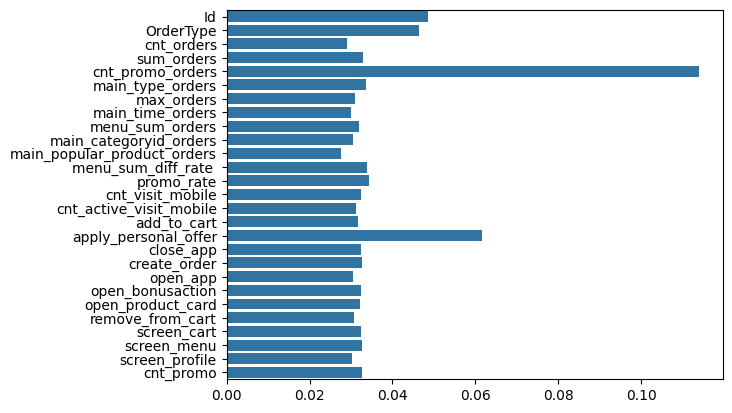

In [ ]:
sns.barplot(x=xgb.feature_importances_, y=xgb.feature_names_in_);

## 4.2 CatBoost

In [ ]:
#тут без оптимизации, подбираю как чувствую
cat = CatBoostClassifier(
    iterations=900, #900
    depth=4, #4
    learning_rate=0.03, #0.03
    l2_leaf_reg=2, #2
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=0
    #,early_stopping_rounds=120 #50
)

cat.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], verbose=200);

print('train score :',roc_auc_score(y_train, cat.predict_proba(X_train)[:, 1]))
print('test score :', roc_auc_score(y_test, cat.predict_proba(X_test)[:, 1]))

cv_splits = cv.split(X, y) 
cv_results = cross_validate(cat, X, y, cv=cv_splits, scoring='roc_auc')
auc_mean = cv_results['test_score'].mean()
print(f'Cross-validated auc: {auc_mean:.3f}')

0:	test: 0.5879284	test1: 0.5971290	best: 0.5971290 (0)	total: 7.91ms	remaining: 7.11s
200:	test: 0.8046179	test1: 0.7946564	best: 0.7947938 (199)	total: 1.4s	remaining: 4.87s
400:	test: 0.8361548	test1: 0.8093791	best: 0.8093948 (395)	total: 2.76s	remaining: 3.44s
600:	test: 0.8611427	test1: 0.8188111	best: 0.8188111 (600)	total: 4.16s	remaining: 2.07s
800:	test: 0.8854081	test1: 0.8279099	best: 0.8279099 (800)	total: 5.53s	remaining: 683ms
899:	test: 0.8961472	test1: 0.8345648	best: 0.8345648 (899)	total: 6.23s	remaining: 0us

bestTest = 0.8345648161
bestIteration = 899

train score : 0.8961471592368129
test score : 0.8345648160655591
Cross-validated auc: 0.808


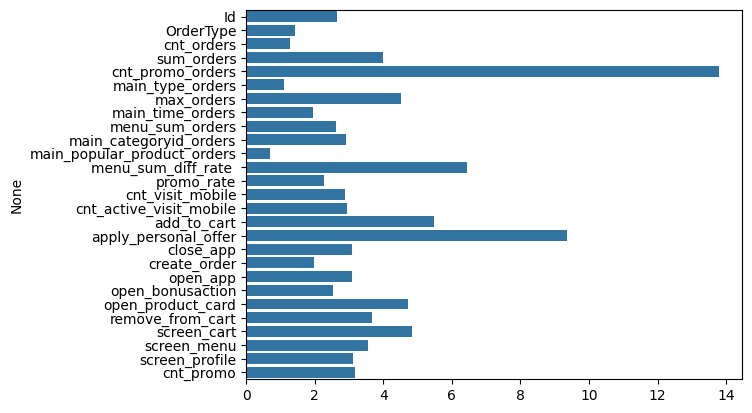

In [ ]:
sns.barplot(x=cat.feature_importances_, y=X_train.columns);

## 4.3 LGBM

In [ ]:
lgbm = LGBMClassifier(
    n_estimators=600, #600
    learning_rate=0.02, #0.02
    max_depth=4, #4
    reg_lambda=5, #5
    random_state=42,
    verbose=-1)

lgbm.fit(X_train, y_train)

print('train score :',roc_auc_score(y_train, lgbm.predict_proba(X_train)[:, 1]))
print('test score :', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1]))

cv_splits = cv.split(X, y) 
cv_results = cross_validate(lgbm, X, y, cv=cv_splits, scoring='roc_auc')
auc_mean = cv_results['test_score'].mean()
print(f'Cross-validated auc: {auc_mean:.3f}')

train score : 0.9072489661724032
test score : 0.8367958935566662
Cross-validated auc: 0.809


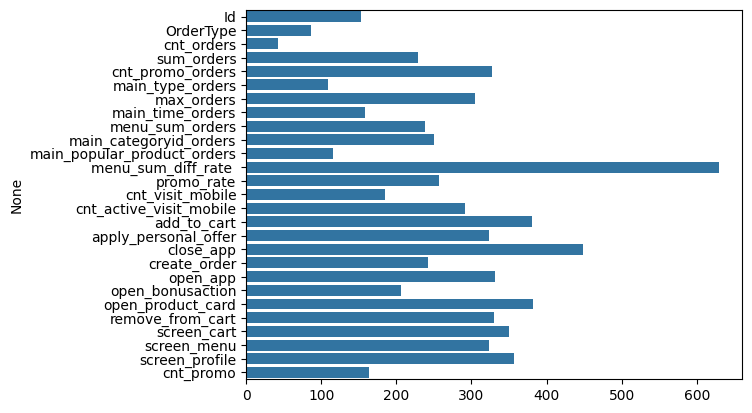

In [ ]:
sns.barplot(x=lgbm.feature_importances_, y=X_train.columns);

## 4.4 VotingClassifier

VotingClassifier считает среднее по нашим моделям. Прирост в качестве по сравнение с отдельной моделью здесь не обязателен. Главная задача - сделать модель не переобученной. Подберем веса к каждой модели.

In [ ]:
def objective(trial):
    # параметры для перебора    
    params = {
        'w1': trial.suggest_float('w1', 0.0, 3.0),
        'w2': trial.suggest_float('w2', 0.0, 3.0),
        'w3': trial.suggest_float('w3', 0.0, 3.0),   
    }


    # модель, передаем в неё сетку параметров
    vc = VotingClassifier(estimators=[('xgb', xgb), ('cat', cat), ('lgbm', lgbm)],
                          voting='soft',
                          weights=[params['w1'], params['w2'], params['w3']])

    # оценивать качество будем на кросс-валидации
    cv_splits = cv.split(X, y)
    cv_scores= cross_validate(vc, X, y, cv=cv_splits, scoring='roc_auc')
    # считаем результат как среднее по фолдам
    cv_evaluation = np.mean(np.abs(cv_scores['test_score']))

    return cv_evaluation

# чтобы не выводить процесс обучения
optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler=TPESampler - метод поиска оптимальных значений (Tree-structured Parzen Estimator)
study = optuna.create_study(sampler=TPESampler(),direction="maximize")

study.optimize(objective, n_trials=30)

# результаты оптимизации
print(f"best optmized auc: {study.best_value:0.5f}")
print(f"best hyperparameters: {study.best_params}")

best optmized auc: 0.82797
best hyperparameters: {'w1': 2.132294937146017, 'w2': 0.4577169669989986, 'w3': 0.2430584136175094}


In [ ]:
VC = VotingClassifier(estimators=[('xgb', xgb), ('cat', cat), ('lgbm', lgbm)],
                      voting='soft', weights=[2.132294937146017,0.4577169669989986, 0.2430584136175094])

#weights=[2.132294937146017,0.4577169669989986, 0.2430584136175094]

VC.fit(X_train, y_train)

print('train score :',roc_auc_score(y_train, VC.predict_proba(X_train)[:, 1]))
print('test score :', roc_auc_score(y_test, VC.predict_proba(X_test)[:, 1]))

cv_splits = cv.split(X, y) 
cv_results = cross_validate(VC, X, y, cv=cv_splits, scoring='roc_auc')
auc_mean = cv_results['test_score'].mean()
print(f'Cross-validated auc: {auc_mean:.3f}')

train score : 0.9476354219433856
test score : 0.8617587464541403
Cross-validated auc: 0.830


# 5. Submit

In [ ]:
#переобучим модель на всех данных
VC.fit(X, y)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='auc',
                                            feature_types=None, gamma=None,
                                            grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints=None,
                                            lear...
                                            multi_strategy=None,
                                            n_estimators=700, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7effa2e9c4c0>),
                             ('lgbm',
                              LGBMClassifier(learning_rate=0.02, max_depth=4,
                                             n_estimators=600, random_state=42,
                                             reg_lambda=5, verbose=-1))],
                 voting='soft',
                 weights=[2.132294937146017, 0.4577169669989986,
                          0.2430584136175094])

In [ ]:
test_sub = test.copy()

test_sub = test_sub.merge(orders_features, on='ClientUUId', how='left')
test_sub = test_sub.merge(mobile_features, on='ClientUUId', how='left')
test_sub = test_sub.merge(promo_features, on='ClientUUId', how='left')

test_sub.OrderType = test_sub.OrderType.apply(lambda x: 1 if x == '1,2,3' else 0)
test_sub.platform_mobile = test_sub.platform_mobile.apply(lambda x: 0 if x == 'android' else 1)
test_sub = test_sub.drop(['LocalBeginDate', 'LocalEndDate', 'ClientUUId'], axis=1)
test_sub = test_sub.drop(to_drop, axis=1, errors='ignore')

test_sub.sum_orders = test_sub.sum_orders.fillna(0)
test_sub.cnt_promo_orders = test_sub.cnt_promo_orders.fillna(0)
test_sub.menu_sum_orders = test_sub.menu_sum_orders.fillna(0)
test_sub.max_orders = test_sub.max_orders.fillna(0)

y_sub = VC.predict_proba(test_sub)[:, 1]

my_submit = pd.DataFrame()
my_submit['apply_promo'] = y_sub
my_submit

,apply_promo
0,0.026417
1,0.116904
2,0.037545
3,0.049390
4,0.037928
...,...
6801,0.006668
6802,0.004103
6803,0.047938
6804,0.071091


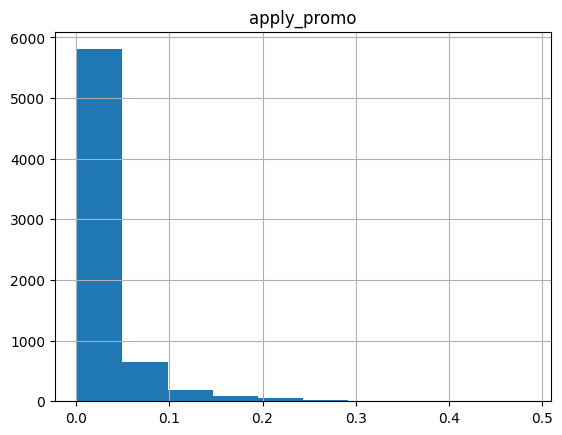

In [ ]:
my_submit.hist();

In [ ]:
my_submit.to_csv('my_submit.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=166046d0-1ac4-4ddc-b425-825ab65686aa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>